In [1]:
import numpy as np
import scvi 
import torch
import pandas as pd
import torch.distributions as dist
import scanpy as sc
from scCFM.models.base.vae import VAE, AE
from scCFM.models.base.geometric_vae import GeometricNBAE,GeometricNBVAE
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from scvi.distributions import NegativeBinomial
from tqdm import tqdm

import scipy as sp
import  matplotlib.pyplot as plt

from typing import Optional

import torch
from torch.distributions import kl_divergence

from stochman.manifold import Manifold
from stochman.curves import BasicCurve, CubicSpline

from scCFM.models.manifold.geodesic import sc_geodesic_minimizing_energy
from scCFM.models.utils import get_distribution
from scCFM.models.manifold.utils import nb_kl

## Geodesic distance

Exploit the manifold object from stochman

In [34]:
def compute_geodesic_dist(manifold, c):
    # Compute the curve and length
    alpha = torch.linspace(0, 1, 100)  # Space of times selected
    traj = c(alpha)  # Computation of the curve at the given times (spline)
    return manifold.curve_length(traj)  # Calculation of the length 

## Single-cell statistical manifold

In [35]:
class scStatisticalManifold(Manifold):
    def __init__(self, model, is_latent=True):
        # The VAE model 
        self.model = model 
        self.is_latent = is_latent  # Whether the manifold is a latent manifold
        
    def curve_energy(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the energy of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        dt = (curve[:, :-1] - curve[:, 1:]).pow(2).sum(dim=-1).sqrt().squeeze(1)  # b
        kl = self._decode_and_kl(curve)
        return torch.sum(kl.view(kl.shape[0], -1), dim=1) * (2 * (dt ** -1))

    def curve_length(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the length of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        kl = self._decode_and_kl(curve)
        return torch.sqrt(2 * torch.sum(kl.view(kl.shape[0], -1), dim=1))

    def connecting_geodesic(self, 
                            p0, 
                            p1, 
                            init_curve: Optional[BasicCurve] = None, 
                            max_iter=100, 
                            eval_grid=100, 
                            lr=1e-4, 
                            minimize_energy=False, 
                            return_losses=True):
        """
        Parameterize a spline as the shortest connecting curve in terms of length (or energy)
        """
        # Decouple curve and library size
        curve = CubicSpline(p0, p1)
        
        # Train the geodesic spline 
        losses = sc_geodesic_minimizing_energy(curve, 
                                                self, 
                                                max_iter=max_iter, 
                                                eval_grid=eval_grid,
                                                lr=lr, 
                                                minimize_energy=minimize_energy, 
                                                return_losses=return_losses)
        return curve, losses

    def metric(self, z, decoder_outputs):    
        """
        The metric is the pullback metric
        """
        # Compute the value of the Fisher matrix
        if self.model.likelihood == "nb":
            nb_fisher = self.model.theta.unsqueeze(0) / \
                (decoder_outputs["mu"] * (self.model.theta.unsqueeze(0) + decoder_outputs["mu"]))  # B x D
        else:
            raise NotImplementedError
        
        # Use the canonical basis vectors to select separate columns of the decoder (speed reasons)
        basis =  torch.eye(z.shape[1])
        basis = basis.unsqueeze(0).expand(z.shape[0], z.shape[1], z.shape[1])  # B x d x d
        
        # Compute the statistical manifold metric tensor 
        jac = []
        for i in range(z.shape[1]):
            _, jac_partial = torch.func.jvp(self.model.decode,
                                            (z,), 
                                            (basis[:, :, i],))  # B x D
            jac.append(jac_partial)

        jac = torch.stack(jac, dim=-1)  # B x D x d
        return torch.einsum("bij,bik->bjk", jac, jac * nb_fisher.unsqueeze(-1))
    
    def _decode_and_kl(self, curve):
        """
        Perform decoding and compute the KL (or other notion of metrics) between successive steps.
        """
        if not self.is_latent:
            decoder_outputs1 = {"mu": curve[:, :-1, :]}
            decoder_outputs2 =  {"mu": curve[:, 1:, :]}
            dist1 = get_distribution(decoder_outputs1, 
                                     self.model.theta, 
                                     likelihood = "nb")
            dist2 = get_distribution(decoder_outputs2, 
                                     self.model.theta, 
                                     likelihood = "nb")
            kl = nb_kl(dist1, dist2)  
        else:
            decoder_outputs1 = self.model.decode(curve[:, :-1, :])
            decoder_outputs2 = self.model.decode(curve[:, 1:, :])
    
            dist1 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs1), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            dist2 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs2), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            kl = nb_kl(dist1, dist2)  
        return kl

# Simulate dataset, same for all

In [36]:
# Set seed for reproducibility
torch.manual_seed(42)

# Parameters
num_genes = 10  # Number of genes
num_cells = 1000  # Number of cells
num_cell_types = 3  # Number of cell types

dist_means = [dist.Normal(torch.zeros(num_genes)+1, torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes), torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes)-1, torch.ones(num_genes))]

In [37]:
# Generate inverse dispersion parameters (theta)
# Assume inverse dispersions are sampled from a gamma distribution
inverse_dispersion = torch.abs(torch.distributions.Gamma(2.0, 1.0).sample((num_genes,)))

# Generate size factors for each cell
size_factors = torch.exp(torch.distributions.LogNormal(0, 0.1).sample((num_cells,)))

# Assign cells to cell types (assuming balanced classes)
cell_type_indices = torch.randint(0, num_cell_types, (num_cells,))

In [38]:
# Initialize the counts matrix
counts = torch.zeros((num_cells, num_genes))
means = torch.zeros((num_cells, num_genes))

# Simulate counts for each cell
for i in range(num_cells):
    cell_type = cell_type_indices[i]
    mean = dist_means[cell_type].sample()
    # mu = size_factors[i] * torch.exp(mean)
    mu = torch.exp(mean)
    theta = inverse_dispersion

    means[i, :] = mu
    counts[i, :] = NegativeBinomial(mu=mu, theta=theta).sample()

# Show the first few simulated counts
print("Simulated Counts Matrix (first 5 cells, all 10 genes):")
print(counts[:5, :])  # Show first 5 cells and all 10 genes

Simulated Counts Matrix (first 5 cells, all 10 genes):
tensor([[ 0.,  0.,  0.,  0., 95.,  0.,  0.,  0.,  6.,  5.],
        [ 0.,  1.,  0.,  0.,  1.,  2.,  7.,  2.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
        [ 1.,  2.,  2.,  1.,  5.,  1.,  4.,  0.,  1.,  3.],
        [ 0.,  3.,  5.,  2.,  0.,  2.,  9.,  0.,  0., 28.]])


# Scanpy visualization

In [39]:
adata = sc.AnnData(X=counts.numpy().copy(), 
                  obs=pd.DataFrame({"cell_type": cell_type_indices.numpy()}))
adata.obs["cell_type"]=adata.obs["cell_type"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


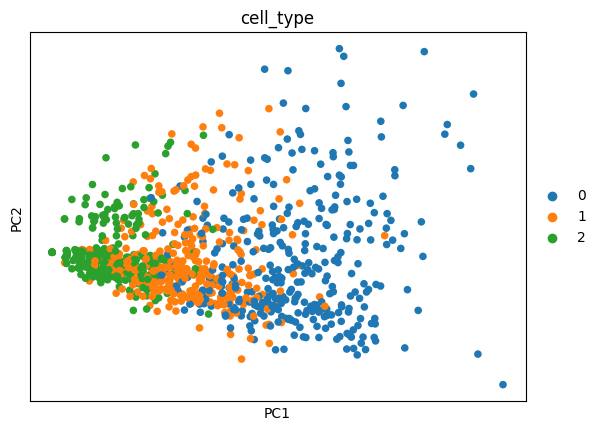

In [41]:
sc.pl.pca(adata, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


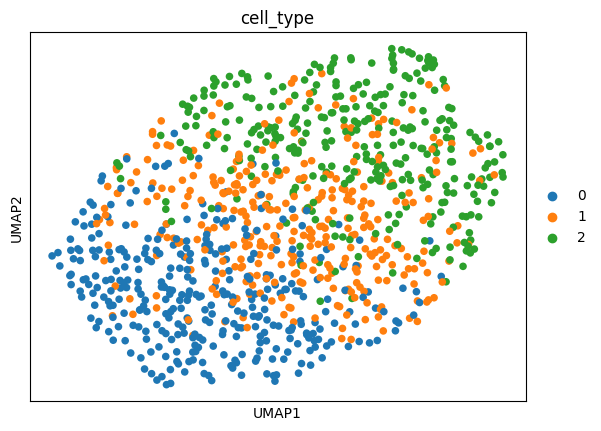

In [42]:
sc.pl.umap(adata, color="cell_type")

In [43]:
class SingleCellDataset(Dataset):
    def __init__(self, counts):
        self.counts = counts

    def __len__(self):
        return len(self.counts)

    def __getitem__(self, idx):
        return {"X": self.counts[idx]}

# Create an instance of the custom dataset
dataset = SingleCellDataset(counts)

# Create a DataLoader to iterate over the dataset
batch_size = 32  # You can choose an appropriate batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Compute results with replicates

In [ ]:
# VAE arguments stay the same
vae_kwargs = dict(in_dim=10,
                    hidden_dims=[5, 2],
                    batch_norm=False,
                    dropout=False,
                    dropout_p=False,
                    n_epochs_anneal_kl=500,
                    kl_warmup_fraction=2,
                    kl_weight=None, 
                    likelihood="nb", 
                    learning_rate=0.001, 
                    model_library_size=False)

# The weights to try 
fl_to_try = [10,7,5,3,1,0]

# Compute Spearman correlation for each row pair
results = {"Weight": [],
             "Spearman": [], 
             "5nn": [], 
             "10nn": [],
             "3nn": []}

# Calculate over three iterations 
for i in range(5):
    print(f"Run {i}")
    # Draw 50 neighbors 
    idx_neighbors = np.random.choice(range(1000), 50)

    # Collect distance matrices for all the different weights 
    distance_matrix_euclidean = {}
    distance_matrix_geodesic = {}
    # Look over lambdas 
    for fl in fl_to_try:
        # Get the distance metrics
        distance_matrix_euclidean[fl] = np.empty((50, 50))
        distance_matrix_geodesic[fl] = np.empty((50, 50))

        # Initialize model 
        if fl == 0:
            model = VAE(**vae_kwargs) 
        else:
            model = GeometricNBVAE(l2=True,
                            interpolate_z=False,
                            eta_interp=0,
                            start_jac_after=0,
                            use_c=False,
                            compute_metrics_every=1,
                            vae_kwargs=vae_kwargs, 
                            detach_theta=False,
                            fl_weight=fl,
                            trainable_c=False,
                            anneal_fl_weight=False, 
                            max_fl_weight=False,
                            n_epochs_anneal_fl=None, 
                            fl_anneal_fraction=None)
    
        # Fit model 
        trainer = Trainer(max_epochs=100, 
                          enable_model_summary=False, 
                          enable_progress_bar=False)
        
        trainer.fit(model=model, 
                    train_dataloaders=dataloader, 
                    val_dataloaders=dataloader)
        
        # Encode counts
        with torch.no_grad():
            encoded_dataset = model.encode(counts)["z"]
        
        # Initialize the manifolds 
        latent_manifold = scStatisticalManifold(model, is_latent=True)
        for i in tqdm(range(50)):
            for j in range(50):
                x_i = encoded_dataset[idx_neighbors[i]]
                x_j = encoded_dataset[idx_neighbors[j]]
                
                # Euclidean distance 
                distance_matrix_euclidean[fl][i,j] = torch.sum((x_i - x_j)**2).item()
                c = latent_manifold.connecting_geodesic(x_i, x_j, minimize_energy=False)[0]
                distance_matrix_geodesic[fl][i,j] = compute_geodesic_dist(latent_manifold, c).item()
            
        del model
        del trainer
        del latent_manifold

    for w in distance_matrix_euclidean:
        results["Weight"].append(w)
        spearmans = []
        for j in range(distance_matrix_euclidean[w].shape[0]): 
            corr, _ = sp.stats.spearmanr(distance_matrix_euclidean[w][j],
                                         distance_matrix_geodesic[w][j], nan_policy="omit")
            spearmans.append(corr)
        results["Spearman"].append(np.mean(spearmans))

        # Add results 
        overlap5 = (((np.argsort(distance_matrix_euclidean[w], axis=1)[:,:5] == np.argsort(distance_matrix_geodesic[w], axis=1)[:,:5]).sum(1))/5).mean()
        overlap10 = (((np.argsort(distance_matrix_euclidean[w], axis=1)[:,:10] == np.argsort(distance_matrix_geodesic[w], axis=1)[:,:10]).sum(1))/10).mean()
        overlap3 = (((np.argsort(distance_matrix_euclidean[w], axis=1)[:,:3] == np.argsort(distance_matrix_geodesic[w], axis=1)[:,:3]).sum(1))/3).mean()
        results["5nn"].append(overlap5)
        results["10nn"].append(overlap10)
        results["3nn"].append(overlap3)

Run 0


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /ictstr01/home/icb/alessandro.palma/environment/scCFM/notebooks/rebuttals/neurips/lightning_logs/version_29537571/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ic

Run 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:20<00:00,  7.61s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:41<00:00,  8.04s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:55<00:00,  8.31s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availab

Run 2


`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:23<00:00,  7.66s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:20<00:00,  7.62s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:25<00:00,  7.70s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:31<00:00,  7.83s/it]
GPU available: True (cuda), us

Run 3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:16<00:00,  7.53s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:19<00:00,  7.59s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:30<00:00,  7.82s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availab

Run 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:34<00:00,  7.88s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████| 50/50 [06:30<00:00,  7.80s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
 30%|███       | 15/50 [01:53<04:29,  7.70s/it]

results

In [20]:
results_df = pd.DataFrame(results)

NameError: name 'results' is not defined

In [21]:
results_df

NameError: name 'results_df' is not defined

In [22]:
res_df = pd.read_csv("results_nns_spearman.csv", index_col=0)

In [23]:
res_df.groupby("Weight").mean()

,Spearman,5nn,10nn,3nn
Weight,,,,
0,0.940862,0.510667,0.348667,0.655556
1,0.953973,0.558667,0.381333,0.677778
3,0.951713,0.636000,0.460667,0.726667
5,0.965597,0.564000,0.409333,0.620000
7,0.963084,0.584000,0.458000,0.657778
10,0.969484,0.626667,0.478667,0.755556


In [24]:
res_df.groupby("Weight").std()/np.sqrt(3)

,Spearman,5nn,10nn,3nn
Weight,,,,
0,0.002610,0.008743,0.011566,0.004444
1,0.003775,0.013532,0.021980,0.005879
3,0.008954,0.038158,0.032338,0.043376
5,0.005207,0.011547,0.019911,0.010184
7,0.011220,0.014048,0.007024,0.008012
10,0.004334,0.027064,0.020827,0.026200


In [25]:
res_df

,Weight,Spearman,5nn,10nn,3nn
0,10,0.974864,0.592,0.444,0.720000
1,7,0.941159,0.596,0.452,0.673333
2,5,0.955418,0.544,0.372,0.633333
3,3,0.933810,0.560,0.396,0.640000
4,1,0.948851,0.532,0.342,0.680000
5,0,0.943734,0.500,0.328,0.646667
24,10,0.960909,0.608,0.476,0.740000
25,7,0.978182,0.556,0.450,0.653333
26,5,0.968780,0.564,0.416,0.600000
27,3,0.960342,0.668,0.494,0.766667
